check if the . is in vocabulary or not

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import  layers
import time

2023-01-07 10:19:33.174241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 10:19:33.372516: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-07 10:19:33.412318: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-07 10:19:34.076168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [1]:
# import tensorflow as tf
import os
import pandas as pd
from matplotlib import image
from skimage.transform import resize
import matplotlib.pyplot as plt


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


2023-01-06 14:49:36.296555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 14:49:36.758191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46703 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:98:00.0, compute capability: 8.6


In [4]:
if tf.config.list_physical_devices('GPU'):
  # Returns a dict in the form {'current': <current mem usage>,
  #                             'peak': <peak mem usage>}
    info = tf.config.experimental.get_memory_info('GPU:0')
print(info)

{'current': 0, 'peak': 0}


In [5]:
df = pd.read_csv("captions.txt")
capts_dt = {}
for i in range(len(df["image"])):
    capts_dt[df["image"][i]] = df["caption"][i]

In [4]:
imgs_names = []
folder = "Images/"
for filename in os.listdir(folder):
        imgs_names.append(filename)  
tot_images = []
for x in imgs_names:
    img = image.imread(folder+x)
    img = resize(img,(224,224))
    tot_images.append(img)
tot_images = np.array(tot_images)

In [7]:
print(tot_images.shape,len(capts_dt))

((8091, 224, 224, 3), 8091)

In [7]:
UNK = '<UNK>' # Unknown word
EOS = '<EOS>' # End of sentence
STR = '<STR>' # start of sentence
# PAD = '<PAD>'

def build_vocabulary(sentences: list, words_to_keep: int) -> list:
    # builds a vocabulary using 'words_to_keep' most frequent words
    # encountered in the list of sentences
    vocabulary = {}
    n = len(sentences)
    for i, s in enumerate(sentences):
        
        # print('Creating vocabulary: %05.2f%%' % (100*(i+1)/n,), end='\r')
        for word in s.strip().split():
            word = word.lower()
            vocabulary[word] = vocabulary.get(word, 0) + 1
    vocabulary = list(vocabulary.items())
    # vocabulary.sort(reverse=True, key=lambda e: e[1])
    # vocabulary = vocabulary[0:words_to_keep]
    vocabulary = [e[0] for e in vocabulary]
    vocabulary.sort()
    vocabulary.append(UNK)
    vocabulary.append(EOS)
    vocabulary.append(STR)
#     vocabulary.append(PAD)

    # print('Done'+(50*' '))
    return vocabulary

def build_sentences(vocabulary: list, sentences: list) -> list:
    # transforms the list of sentences into a list of lists of words
    # replacing words that are not in the vocabulary with <UNK>
    # and appending <EOS> at the end of each sentence
    processed_sent = []
    n = len(sentences)
    vocabulary = set(vocabulary)
    for i, sent in enumerate(sentences):
        # print('Creating sentences list: %05.2f%%' % (100*(i+1)/n,), end='\r')
        s = [STR]
        for word in sent.strip().split():
            word = word.lower()
            if word not in vocabulary:
                word = UNK
            s.append(word)
        s.append(EOS)
        processed_sent.append(s)
    # print('Done'+(50*' '))
    return processed_sent

def word2index(vocabulary: list, word: str) -> int:
    # returns the index of 'word' in the vocabulary
    return vocabulary.index(word)

def words2onehot(vocabulary: list, words: list) -> np.ndarray:
    # transforms the list of words given as argument into
    # a one-hot matrix representation using the index in the vocabulary
    n_words = len(words)
#     print(words)
    n_voc = len(vocabulary)
    indices = np.array([word2index(vocabulary, word) for word in words])
    a = np.zeros((n_words, n_voc))
    a[np.arange(n_words), indices] = 1
    return a

def sample_word(vocabulary: list, prob: np.ndarray) -> str:
    # sample a word from the vocabulary according to 'prob'
    # probability distribution (the softmax output of our model)
    # until it is != <UNK>
    while True:
        word = np.random.choice(vocabulary, p=prob)
        if word != UNK:
            return word

In [8]:
vocabulary = build_vocabulary(df['caption'].values.tolist(), words_to_keep=1)


for x in imgs_names:
    dum_sent = capts_dt[x]
    dum_sent = dum_sent.lower()
    if(dum_sent[-1]=="."):
        capts_dt[x] = dum_sent[:-1]
        


tot_captions = []
for c in imgs_names:
    tot_captions.append(capts_dt[c])
    

total_built_sents = build_sentences(vocabulary,tot_captions)
total_ohv = []

for sen in total_built_sents:
    total_ohv.append(words2onehot(vocabulary,sen))


In [15]:
# print(vocabulary.index("<STR>"))

In [17]:
class rnn_dec(keras.Model):

    def __init__(self,voc_size, **kwargs):
        super(rnn_dec, self).__init__(**kwargs)
        self.cel_dec_fro = tf.keras.layers.LSTMCell(512,activation = "relu",recurrent_dropout = 0.3)
        self.rnn_dec_fro = tf.keras.layers.RNN(self.cel_dec_fro,return_sequences = True)
        self.pre_out = tf.keras.layers.Dense(128,activation = "relu")
        self.out = tf.keras.layers.Dense(voc_size,activation = 'softmax',kernel_regularizer = tf.keras.regularizers.L2(0.01))

    def call(self, img_features,train_caption):
        xx = self.rnn_dec_fro(train_caption,initial_state = [img_features,img_features])
        xx = self.pre_out(xx)
        xx = self.out(xx)
        return xx

In [18]:
my_model = rnn_dec(len(vocabulary))
optim = keras.optimizers.Adam()
loss = keras.losses.CategoricalCrossentropy()


base_model = tf.keras.applications.vgg16.VGG16(include_top = False,input_shape = (224, 224, 3),pooling = 'avg')
print(len(base_model.layers))
for layers in base_model.layers:
    layers.trainable = False


20


In [15]:
#caching the image features from vgg net

vgg_encodes = []
for x in tot_images:
    inp = np.expand_dims(x, axis = 0)
    vgg_encodes.append(base_model(inp))

2023-01-06 14:58:04.993197: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-06 14:58:05.674109: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [20]:
epochs = 80
st_time = time.time()
losses = []
for dum in range(epochs):
    epoch_loss = 0
    for cnt in range(len((imgs_names))):
#         if(cnt%1000 == 0):
#             print("cur is :", cnt/1000)       
        sent_inp = total_ohv[cnt][:-1]
        sent_inp = np.expand_dims(sent_inp,axis=0)
                     
        y_tr = total_ohv[cnt][1:]
        
        vgg_enc = vgg_encodes[cnt]
        y = (tf.keras.layers.RepeatVector(len(sent_inp[0])))(vgg_enc)
        rnn_inp = (tf.keras.layers.Concatenate(axis = 2))([sent_inp,y])
        
        with tf.GradientTape() as tp:
            out = my_model(vgg_enc,rnn_inp)
            ls = loss(y_tr,out[0])
        
        grads = tp.gradient(ls,my_model.trainable_weights)
        optim.apply_gradients(zip(grads,my_model.trainable_weights))
        epoch_loss += ls
        my_model.cel_dec_fro.reset_recurrent_dropout_mask()
#         my_model.cel_dec_back.reset_recurrent_dropout_mask()
    losses.append(epoch_loss/len(imgs_names))
    print(dum+1,epoch_loss)
end_time = time.time()

tot_time = (end_time-st_time)/60
print("total time",tot_time)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/sandeep/.local/lib/python3.8/site-packages/keras/backend.py", line 5130, in <genexpr>
    ta.write(ta_index_to_write, out)  File "/home/sandeep/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
1 tf.Tensor(39516.344, shape=(), dtype=float32)
2 tf.Tensor(33490.996, shape=(), dtype=float32)
3 tf.Tensor(31157.475, shape=(), dtype=float32)
4 tf.Tensor(29645.17, shape=(), dtype=float32)
5 tf.Tensor(28441.271, shape=(), dtype=float32)
6 tf.Tensor(27460.264, shape=(), dtype=float32)
7 tf.Tensor(26548.62, shape=(), dtype=float32)
8 tf.Tensor(25728.84, shape=(), dtype=float32)
9 tf.Tensor(24937.611, shape=(), dtype=float32)
10 tf.Tensor(24212.55,

In [21]:
my_model.save("captioning_model")

INFO:tensorflow:Assets written to: captioning_model/assets


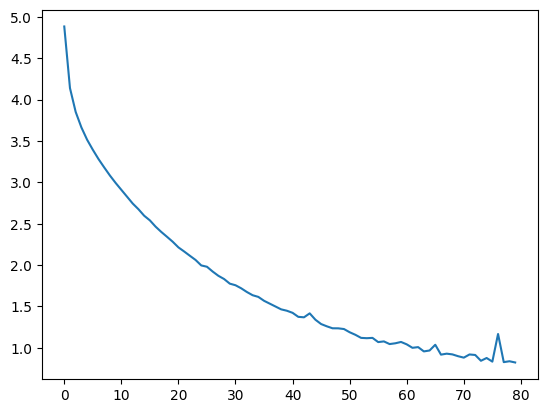

In [22]:
plt.plot(losses)

In [35]:
def gen_sent(img,vocab):
    st = ""
#     print(img.shape)
    vgg_enc = base_model(img)
#     print(vgg_enc.shape)
    st_ind = vocab.index("<STR>")
    st_inp = np.zeros([1,len(vocab)])
    st_inp[0][st_ind] = 1
    st_inp = (tf.keras.layers.Concatenate(axis = 1))([st_inp,vgg_enc])
    
    ot,ot2 = my_model.cel_dec_fro(st_inp,[vgg_enc,vgg_enc],training = False)

    pre_out = my_model.pre_out(ot,training = False)
    sfmx = my_model.out(pre_out,training = False)
    ind = tf.argmax(sfmx,1)
    
    end_ind = vocab.index("<EOS>")
    unk_ind = vocab.index("<UNK>")
    
    while(ind!=end_ind):
        if(ind==unk_ind):
            ind = pre_ind
            continue
#         print(st)
        st = st+vocab[int(ind)]+" "
        nex_wd = np.zeros([1,len(vocab)])
        nex_wd[0][ind] = 1
        nex_wd = (tf.keras.layers.Concatenate(axis = 1))([nex_wd,vgg_enc])
        ot,ot2 = my_model.cel_dec_fro(nex_wd,ot2,training = False)
        pre_out = my_model.pre_out(ot,training = False)
        sfmx = my_model.out(pre_out,training = False)
        pre_ind = ind
        ind = tf.argmax(sfmx,1)

    return st






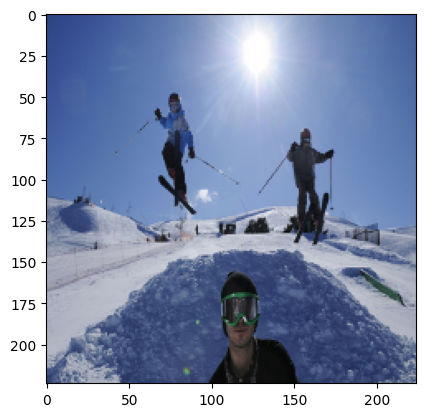

In [6]:
plt.imshow(tot_images[2990])

In [44]:
sent = gen_sent(np.expand_dims(tot_images[2990],axis = 0),vocabulary)
print(sent)
print(len(sent.strip().split()))

two shirtless teenage boys splashing in the snow covered mountain 
10
